# Crop Weed Detection
Crop weeds are weeds that grow amongst crops. Despite the potential for some crop weeds to be used as a food source, many can also prove harmful to crops, both directly and indirectly. Crop weeds can inhibit the growth of crops, contaminate harvested crops and often spread rapidly.And hence it is necessary for the farmers to detect weed and remove them in order to protect their plants and crops.

## Importing the dataset

In [1]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/Weed.zip"
!unzip -qo Weed.zip 
!rm Weed.zip

--2020-11-30 13:20:09--  https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/Weed.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.12
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386990 (378K) [application/x-zip-compressed]
Saving to: ‘Weed.zip’

Weed.zip            100%[===================>] 377.92K  --.-KB/s    in 0.004s  

2020-11-30 13:20:09 (88.4 MB/s) - ‘Weed.zip’ saved [386990/386990]



## Installing the necessary modules and importing the dependencies

In [2]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils 

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from tensorflow.keras.models import Model,load_model
from sklearn.utils import shuffle 


from tensorflow.keras.models import Sequential
from keras.layers import Reshape

from sklearn.model_selection import train_test_split

In [4]:
# Defining the dataset directory
image_dir="weed-no-weed/"

## Creating a new folder to store augmented images

In [5]:
# Defining t=directory to store augmented images 
os.makedirs('weeds-not-weeds/augmented-images')
os.makedirs('weeds-not-weeds/augmented-images/yes')
os.makedirs('weeds-not-weeds/augmented-images/no')

In [6]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [7]:
augmented_data_path ='weeds-not-weeds/augmented-images/'

augment_data(file_dir=image_dir+'weed',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

augment_data(file_dir=image_dir+'not_weed', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

## Loading the data and preparing it for Model Training

In [8]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            #image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [9]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 171
X shape is: (171, 224, 224, 3)
y shape is: (171, 1)


## Data Visualization

In [10]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Weed Crop: {label_to_str(label)}")
        plt.show()

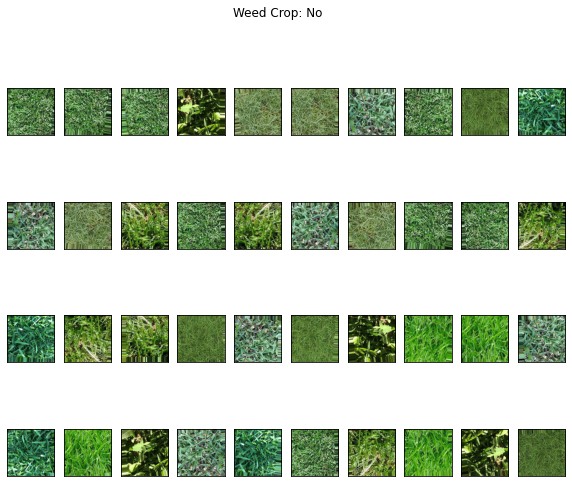

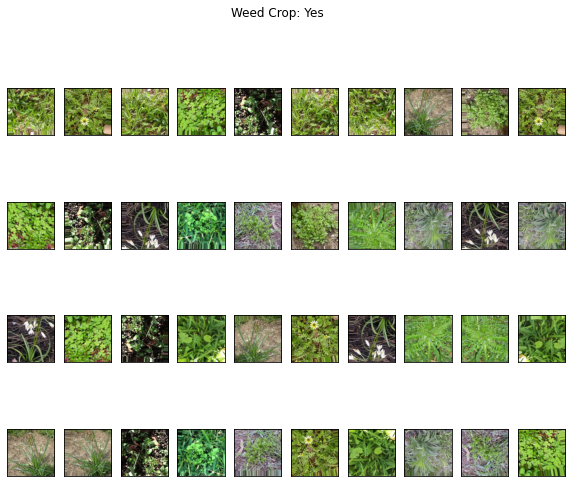

In [11]:
plot_sample_images(X, y)

## Test-Train Split

In [12]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = split_data(X, y, test_size=0.15)


In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 145
number of test examples = 26


## Defining Model Architecture

In [16]:
# Model creation with changes

model = VGG16(input_shape=(224,224,3),include_top=False)

for layer in model.layers:
    layer.trainable = False

newModel = model.output
newModel = AveragePooling2D()(newModel)
newModel = Flatten()(newModel)
newModel = Dense(128, activation="relu")(newModel)
newModel = Dropout(0.5)(newModel)
newModel = Dense(1, activation='sigmoid')(newModel)

model = Model(inputs=model.input, outputs=newModel)

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [18]:
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

## Model Training

In [19]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))    

Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 0.7525 - accuracy: 0.4897 - val_loss: 0.7304 - val_accuracy: 0.3846
Epoch 2/10
5/5 [==============================] - 16s 3s/step - loss: 0.6429 - accuracy: 0.6069 - val_loss: 0.6337 - val_accuracy: 0.5769
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 0.5540 - accuracy: 0.6897 - val_loss: 0.4911 - val_accuracy: 0.8846
Epoch 4/10
5/5 [==============================] - 16s 3s/step - loss: 0.5375 - accuracy: 0.7448 - val_loss: 0.4701 - val_accuracy: 0.9231
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: 0.5077 - accuracy: 0.8138 - val_loss: 0.4710 - val_accuracy: 0.8846
Epoch 6/10
5/5 [==============================] - 16s 3s/step - loss: 0.4571 - accuracy: 0.7862 - val_loss: 0.4466 - val_accuracy: 0.8846
Epoch 7/10
5/5 [==============================] - 16s 3s/step - loss: 0.3876 - accuracy: 0.8690 - val_loss: 0.4077 - val_accuracy: 0.9231
Epoch 8/10
5/5 [==================

## Training Plots

Text(0.5, 1.0, 'Accuracy Curves')

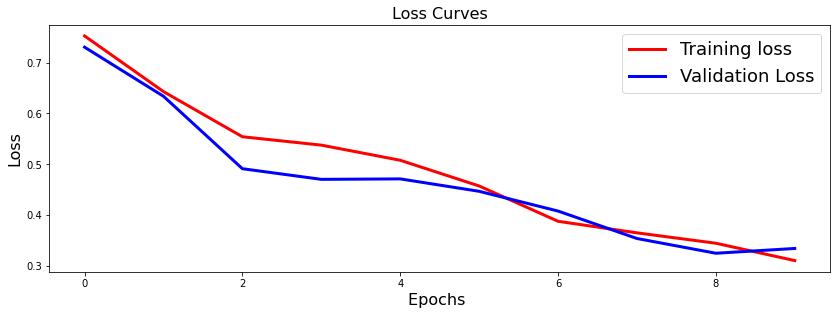

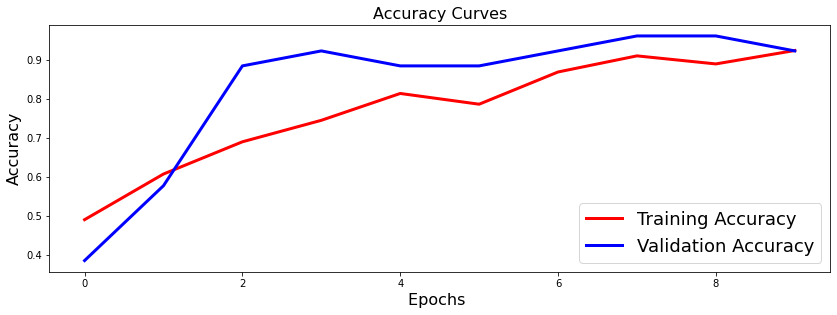

In [20]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [21]:
model.save("Weed.h5")

In [22]:
image = cv2.imread("weed-no-weed/not_weed/11858d2a42ad30b668f0764530a00a67.jpg")
image = cv2.resize(image, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
# normalize values
image = image / 255.    
image = np.array(image)
test_image = np.expand_dims(image,axis=0)

Not Weed


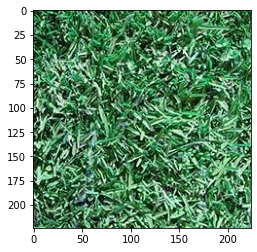

In [23]:
result = model.predict(test_image)
if result > 0.5:
    print("Weed")
else:
    print("Not Weed")
plt.imshow(image)

In [24]:
image = cv2.imread("weed-no-weed/weed/6aa7fa3ff04411b410c46c9213575dc6.jpg")
image = cv2.resize(image, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
# normalize values
image = image / 255.    
image = np.array(image)
test_image = np.expand_dims(image,axis=0)

Weed


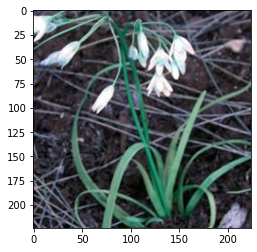

In [25]:
result = model.predict(test_image)
if result > 0.5:
    print("Weed")
else:
    print("Not Weed")
plt.imshow(image)

In [26]:
!deepCC Weed.h5

reading [keras model] from 'Weed.h5'
Saved 'Weed.onnx'
reading onnx model from file  Weed.onnx
Model info:
  ir_vesion :  5 
  doc       : 
WARN (ONNX): graph-node block1_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block1_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv3's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv3's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block5_conv1's a